# (08) DOVES—Laplace—Lin—2

**Motivation**: New defaults fit + ```laplace```. Device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 2
device = f'cuda:{device_idx}'

model_type = 'laplace'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 512, 'enc_type': 'lin', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'Normal', 'init_scale': 0.05}

Trainer:
{'temp_anneal_portion': 0.0, 'temp_stop': 1.0, 'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': 
{'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 0.0}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  LaplaceVAE |  393.2 K   |
|     ---     |    ---     |
|    fc_enc   |  262.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

laplace_DOVES_z-512_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_gr(500)_(2024_05_08,21:41)

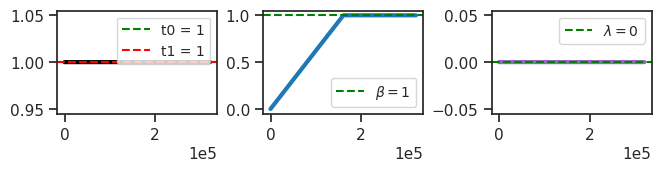

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
print(vae)

LaplaceVAE(
  (mse): MSELoss()
  (fc_enc): Linear(in_features=256, out_features=1024, bias=False)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

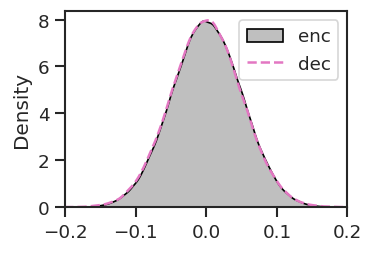

In [7]:
fig, ax= create_figure(dpi=120)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.2, 0.2))
add_legend(ax)
plt.show()

### Train

In [8]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 168.609230: 100%|███████████████████████| 3000/3000 [46:39<00:00,  1.07it/s]


### Loss vld (freeze)

In [11]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 126.87165, 'kl': 40.449867, 'kl_diag': 0.07850796, 'tot': 167.32152}

### Identify dead neurons

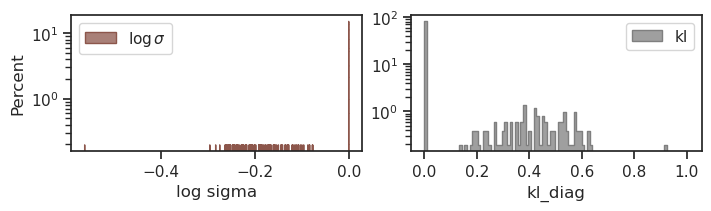

In [12]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [18]:
dead_thres = 10e-2
dead = loss['kl_diag'] < dead_thres
dead.sum()

416

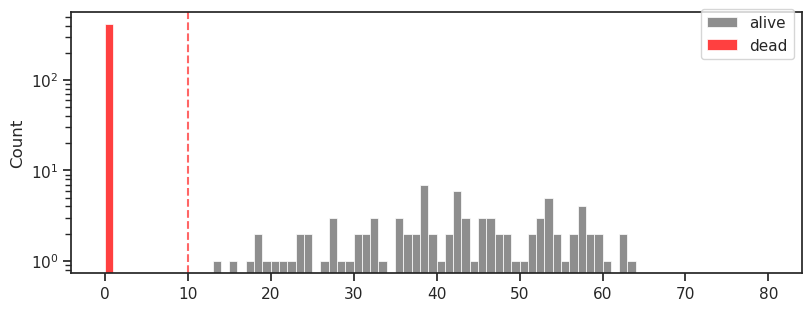

In [19]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
move_legend(ax, (1., 1.04))
plt.show()

### Plot dec weights

In [20]:
dead.sum() / 32

13.0

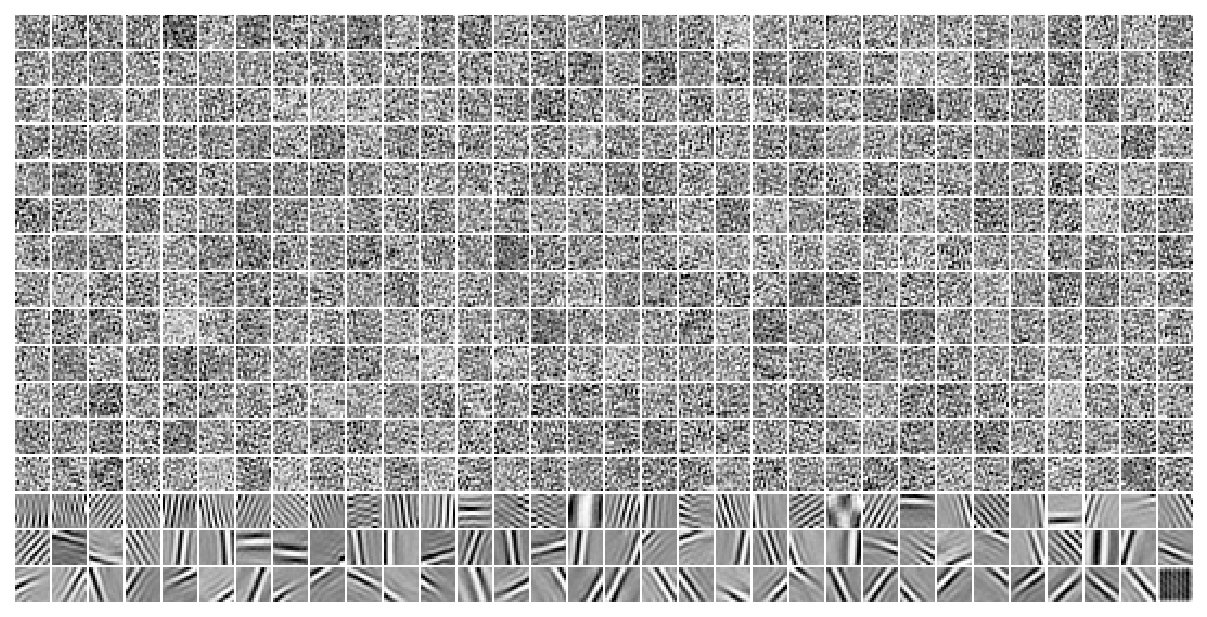

In [21]:
vae.show(dpi=150, order=np.argsort(loss['kl_diag']));